In [1]:
import numpy as np
from feos.si import *
from feos.uvtheory import UVParameters, Perturbation, VirialOrder
from feos.eos import State, PhaseEquilibrium, PhaseDiagram, EquationOfState, Contributions
import matplotlib.pyplot as plt

**Thol EoS for Comparison**

In [2]:
# Parameters for Thol EoS:
A = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
              2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
N = np.array([0.005208073, 2.186252000, -2.161016000, 1.452700000, -2.041792000, 0.186952860, -0.090988445, 
              -0.497456100, 0.109014310, -0.800559220, -0.568839000, -0.620862500, -1.466717700, 1.891469000, 
              -0.138370100, -0.386964500, 0.126570200, 0.605781000, 1.179189000, -0.477326790, -9.921857500, -0.574793200, 0.003772923])
T = np.array([1.000, 0.320, 0.505, 0.672, 0.843, 0.898, 1.294, 2.590, 1.786, 2.770, 1.786,
              1.205, 2.830, 2.548, 4.650, 1.385, 1.460, 1.351, 0.660, 1.496, 1.830, 1.616, 4.970])
D = np.array([4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 2.0, 2.0, 3.0, 1.0,
              1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0])
L = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0,
              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
ETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.067, 1.522,
                8.82, 1.722, 0.679, 1.883, 3.925, 2.461, 28.2, 0.753, 0.82])
BETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.625,
                 0.638, 3.91, 0.156, 0.157, 0.153, 1.16, 1.73, 383, 0.112, 0.119])
GAMMA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.71,
                  0.86, 1.94, 1.48, 1.49, 1.945, 3.02, 1.11, 1.17, 1.33, 0.24])
EPSILON = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2053,
                    0.409, 0.6, 1.203, 1.829, 1.397, 1.39, 0.539, 0.934, 2.369, 2.43])

class Thol:
    def __init__(self, sigma, eps_k):
        self.sigma = sigma * ANGSTROM
        self.eps_k = eps_k * KELVIN
        self.tc = 1.32 * self.eps_k / KELVIN
        self.rhoc = 0.31 / self.sigma**3 * ANGSTROM**3
        
    def components(self): 
        return 1
    
    def subset(self, components):
        return self
        
    def molar_weight(self):
        return np.array([1.0])
    
    def max_density(self, moles):
        return 0.04
    
    def helmholtz_energy(self, state):
        """
        state (StateHD):
            temperature in Kelvin als Float, Dual oder HD oder HD3, HDD, HDD3,
            partial_density in # / Angstrom^3
            volume in Angstrom^3
            moles in mol
        """
        tau = self.tc / state.temperature
        delta = np.sum(state.partial_density) / self.rhoc
        a = 0.0 #zero(state)
        
       # print("v", state.volume)
       # print("n", state.moles)
        #print("partial density", state.partial_density)
        #print("1")
       # print("delta: {}".format(delta))
      #  print("tau: {}".format(tau))
        
        for i in range(6):
            a = a + N[i] * delta**D[i] * tau**T[i]
        
       # print("2")
        for i in range(6, 12):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
       # print("3")
        for i in range(12, 23):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)
        return a * np.sum(state.moles)

---

**Class for dimensionless evaluation of LJ / Mie EoS**

In [3]:
class EOS_PROPERTIES():
    def __init__(self, eos, sigma=3.7039, eps_k=150.03,  rep=12, att=6.0):
        """Python class for the dimensionless evaluation of pure Mie-nu-6 EoS
            Input:  EquationOfState from feos,
                    Optional: diameter sigma, eps / kB, repulsive exponent rep, attractive exponent att
        """
        self.sigma = sigma
        self.nu = rep
        self.eps_k = eps_k
        self.eos = eos     
        
    def eos_state(self, temp, rho): 
                temperature = temp * self.eps_k * KELVIN
                density = rho / (self.sigma**3 * ANGSTROM**3 * NAV)
                return State(self.eos, temperature=temperature,  density=density) 
            
    ##### dimensionless quantities ###########
    def res_helmholtz_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).helmholtz_energy(Contributions.ResidualNvt) / (KB * temperature)
    
    def tot_helmholtz_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).helmholtz_energy() / (KB * temperature)
    
    def internal_energy(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).internal_energy(Contributions.ResidualNvt) / (KB * temperature) * temp
    
    def chemical_potential(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return (self.eos_state(temp, rho).chemical_potential(Contributions.ResidualNvt) / RGAS / temperature)[0] * temp
    
    def total_pressure(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        p_vec = self.eos_state(temp, rho).pressure() * (self.sigma)**3 * ANGSTROM**3 /(KB * temperature) * temp
        return p_vec
    
    def residual_pressure(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        p_vec = self.eos_state(temp, rho).pressure(Contributions.ResidualNvt) * (self.sigma)**3 * ANGSTROM**3 /(KB * temperature) * temp
        return p_vec
    
    def heat_capacity_cv(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).c_v(Contributions.ResidualNvt) / (RGAS) + 3.0 / 2.0  ## total
    
    def heat_capacity_cp(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos_state(temp, rho).c_p(Contributions.ResidualNvt) / (RGAS) + 5.0 / 2.0
    
    def compressibility(self, rho, temp):
        return self.eos_state(temp, rho).compressibility()
    
    def isothermal_compressibility(self, rho, temp):  # beta_t = 1 / rho*(dp/drho)
        return -1.0 / (self.eos_state(temp, rho).dp_dv() / self.eos_state(temp, rho).density) * KB * self.eps_k * KELVIN * NAV / (self.sigma**3 * ANGSTROM**3)
   
    def thermal_pressure_coefficient(self, rho, temp):
        return self.eos_state(temp, rho).dp_dt() /  KB * self.sigma**3 * ANGSTROM**3
    
    def thermal_expansion_coefficient(self, rho, temp):
        return self.thermal_pressure_coefficient(rho, temp) * self.isothermal_compressibility(rho, temp)
    
    def isotropic_compressibility(self, rho, temp):
        return self.eos_state(temp, rho).isentropic_compressibility() * self.eps_k * KELVIN * KB / (self.sigma**3 * ANGSTROM**3)
    
    def speed_of_sound(self, rho, temp):  
        return (self.heat_capacity_cp(rho, temp) / self.heat_capacity_cv(rho, temp) / rho / self.isothermal_compressibility(rho, temp))**0.5
        
    
    def joule_thomson(self, rho, temp):
        temperature = temp * self.eps_k * KELVIN
        return (self.isothermal_compressibility(rho, temp) * self.thermal_pressure_coefficient(rho, temp) * temp - 1.0) / (rho * self.heat_capacity_cp(rho, temp))
    
    def grueneisen_parameter(self, rho, temp):
        return self.eos_state(temp, rho).dp_dt() / (rho * self.heat_capacity_cv(rho, temp)) /  KB * self.sigma**3 * ANGSTROM**3
    
    def enthalpy(self, rho, temp):
        return  self.eos_state(temp, rho).enthalpy() / (KB * self.eps_k * KELVIN) 
    
    ############ Virial coefficients ###############################
    def second_virial_coefficient(self, temp):
        temperature = temp * self.eps_k * KELVIN
        return self.eos.second_virial_coefficient(temperature) / (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def third_virial_coefficient(self, temp):  # Recheck!
        temperature = temp * self.eps_k * KELVIN
        return  self.eos.third_virial_coefficient(temperature)  / (self.sigma**3 * ANGSTROM**3 * NAV)**2 
    
    ##### VLE #####
    def vapor_pressure(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.vapor_pressure(self.eos, temperature)[0] * self.sigma**3 * ANGSTROM**3 / (self.eps_k * KELVIN * KB)
    
    def critical_point(self, initial_temp = 340*KELVIN ):
        return State.critical_point(self.eos, initial_temperature=initial_temp)
    
    def critical_pressure(self):
        return State.critical_point(self.eos, initial_temperature=100*KELVIN).pressure() * self.sigma**3 * ANGSTROM**3 / (self.eps_k * KELVIN * KB)
    
    def critical_density(self):
        return self.critical_point().density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def critical_temperature(self):
        return self.critical_point().temperature / (self.eps_k * KELVIN)
    
    def vle_pressure(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR)
    
    def vle_pressure_temperature(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR).temperature / (self.eps_k * KELVIN)
    
    def vle_pressure_density(self, p):
        return PhaseEquilibrium.pure_p(self.eos, p * BAR).vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV), VLEState.pure_p(self.eos, p * BAR).liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def vle_temperature(self, temp):
        temperature = temp * self.eps_k * KELVIN
        return PhaseEquilibrium.pure_t(self.eos, temperature)
    
    def vle_temperature_dimensionless(self, temp):
        vle = self.vle_temperature(temp)
        return vle.vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV), vle.liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def vapor_density(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.vapor.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def liquid_density(self, temp):
        temperature = temp * self.eps_k * KELVIN
        vle = PhaseEquilibrium.pure(self.eos, temperature)
        return vle.liquid.density * (self.sigma**3 * ANGSTROM**3 * NAV)
    
    def enthalpy_of_vaporization(self, temp):
        temperature = temp * self.eps_k * KELVIN
        hv = self.enthalpy(self.vapor_density(temp), temp)
        hl = self.enthalpy(self.liquid_density(temp), temp)
        dhv = hv - hl
        return dhv


---

**Define different Versions of the uv-theroy**
- WCA uv-theory [J. Chem. Phys. 155, 244501 (2021)]
- BH uv-theory [J. Chem. Phys. 155, 244501 (2021)]
- uv-$B_3$-theory [to be published]

In [4]:
def get_eos(name,  rep, sigma = 3.7039, eps_k = 150.03, att=6.0):
    nu = rep
            
    if name == 'thol':
        eos = EquationOfState.python(Thol(sigma, eps_k))
        
    if name == 'uv_wca':
        parameters = UVParameters.from_lists([rep], [att], [sigma], [eps_k])
        eos = EquationOfState.uvtheory(parameters, perturbation=Perturbation.WeeksChandlerAndersen, virial_order=VirialOrder.Second)
        
    if name == 'uv_bh':
        parameters = UVParameters.from_lists([rep], [att], [sigma], [eps_k])
        eos = EquationOfState.uvtheory(parameters, perturbation=Perturbation.BarkerHenderson, virial_order=VirialOrder.Second) 

    if name == 'uv_b3':
        parameters = UVParameters.from_lists([rep], [att], [sigma], [eps_k])
        eos = EquationOfState.uvtheory(parameters, perturbation=Perturbation.WeeksChandlerAndersen, virial_order=VirialOrder.Third)
        
        
    return EOS_PROPERTIES(eos, sigma=sigma, eps_k=eps_k, rep=rep, att=att)
    

## **Examples**

In [5]:
rep = 12
att = 6.0
sigma = 3.7039 # in Angstrom
eps_k = 150.03 # eps / kB in K
thol = get_eos('thol', rep, sigma, eps_k, att)
uv_bh = get_eos('uv_bh', rep, sigma, eps_k, att)
uv_wca = get_eos('uv_wca', rep, sigma, eps_k, att)
uv_b3 =  get_eos('uv_b3', rep, sigma, eps_k, att)

**Lennard-Jones (LJ) Virial coefficients**

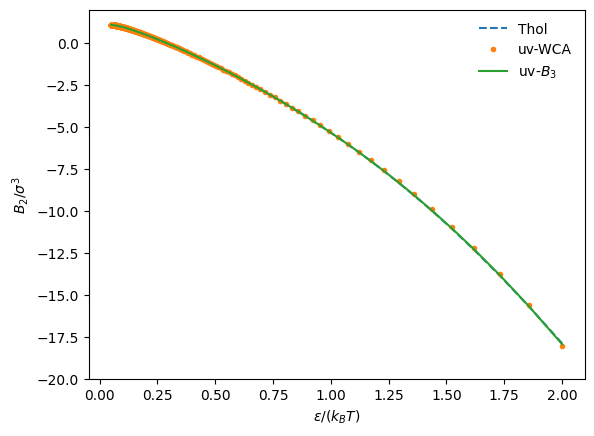

In [9]:
def plot_second_virial_coeff():
    tvec = np.linspace(0.5, 20, 500)
    b2_thol = []
    b2_uv_wca  = []
    b2_uv_bh = []
    b2_uv_b3 = []
    for temp in tvec:
        b2_thol.append(thol.second_virial_coefficient(temp))
        b2_uv_wca.append(uv_wca.second_virial_coefficient(temp))
        b2_uv_bh.append(uv_bh.second_virial_coefficient(temp))
        b2_uv_b3.append(uv_b3.second_virial_coefficient(temp))

    plt.plot(1/tvec, b2_thol, '--', label='Thol')
    #plt.plot(1/tvec, b2_uv_bh, ':', label='uv-BH')
    plt.plot(1/tvec, b2_uv_wca, '.', label='uv-WCA')
    plt.plot(1/tvec, b2_uv_b3, label='uv-$B_3$')
    plt.ylim(-20, 2)
    plt.ylabel('$B_2 / \\sigma^3$')
    plt.xlabel('$\\varepsilon/(k_BT)$')
    plt.legend(frameon=False)
    return
plot_second_virial_coeff()

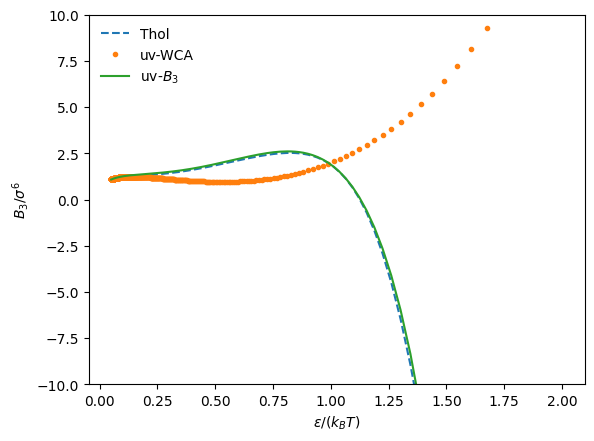

In [10]:
def plot_third_virial_coeff():
    tvec = np.linspace(0.5, 20, 800)
    b2_thol = []
    b2_uv_wca  = []
    b2_uv_bh = []
    b2_uv_b3 = []
    for temp in tvec:
        b2_thol.append(thol.third_virial_coefficient(temp))
        b2_uv_wca.append(uv_wca.third_virial_coefficient(temp))
        b2_uv_bh.append(uv_bh.third_virial_coefficient(temp))
        b2_uv_b3.append(uv_b3.third_virial_coefficient(temp))

    plt.plot(1/tvec, b2_thol, '--', label='Thol')
    #plt.plot(1/tvec, b2_uv_bh, ':', label='uv-BH')
    plt.plot(1/tvec, b2_uv_wca, '.', label='uv-WCA')
    plt.plot(1/tvec, b2_uv_b3, label='uv-$B_3$')
    plt.ylim(-10, 10)
    plt.ylabel('$B_3 / \\sigma^6$')
    plt.xlabel('$\\varepsilon/(k_BT)$')
    plt.legend(frameon=False)
    return
plot_third_virial_coeff()

**LJ Isotherms**

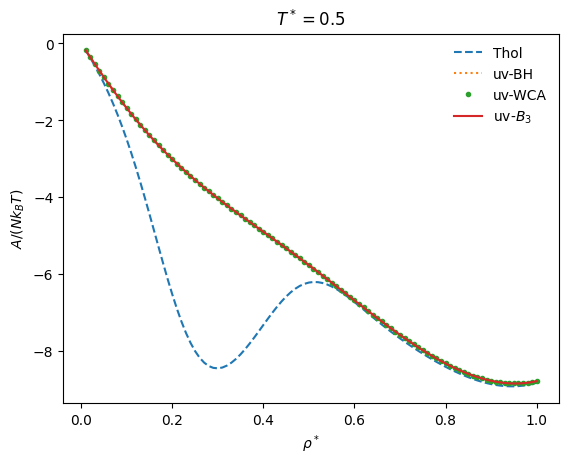

In [192]:
def plot_helmholtz_energy(temperature, dimensionless_density = np.linspace(0.01, 1.1, 100)):
    
    a_thol = []
    a_uv_bh = []
    a_uv_wca = []
    a_uv_b3 = []
    for rho in dimensionless_density:
        a_thol.append(thol.res_helmholtz_energy(rho, temperature))
        a_uv_bh.append(uv_bh.res_helmholtz_energy(rho, temperature))
        a_uv_wca.append(uv_bh.res_helmholtz_energy(rho, temperature))
        a_uv_b3.append(uv_b3.res_helmholtz_energy(rho, temperature))
        
    plt.plot(dimensionless_density, a_thol, '--', label='Thol')
    plt.plot(dimensionless_density, a_uv_bh, ':', label='uv-BH')
    plt.plot(dimensionless_density, a_uv_wca, '.', label='uv-WCA')
    plt.plot(dimensionless_density, a_uv_bh, label='uv-$B_3$')
    plt.xlabel('$\\rho^*$')
    plt.ylabel('$A/(Nk_BT)$')
    plt.title('$T^*={}$'.format(temperature))
    plt.legend(frameon=False)
    return
plot_helmholtz_energy(temperature=0.5, dimensionless_density=np.linspace(0.01, 1.0, 100))

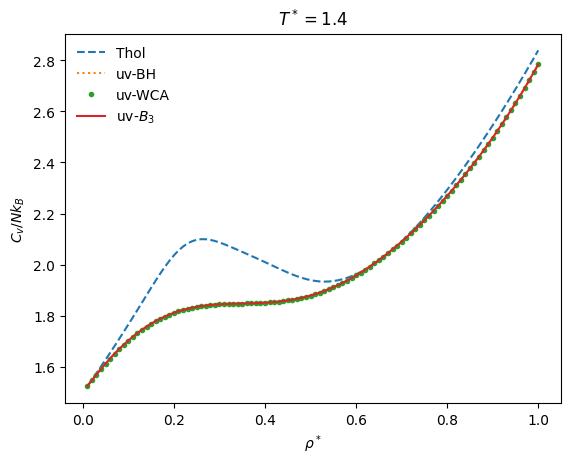

In [193]:
def plot_heat_capcities(temperature):
    dimensionless_density = np.linspace(0.01, 1.0, 100)
    a_thol = []
    a_uv_bh = []
    a_uv_wca = []
    a_uv_b3 = []
    for rho in dimensionless_density:
        a_thol.append(thol.heat_capacity_cv(rho, temperature))
        a_uv_bh.append(uv_bh.heat_capacity_cv(rho, temperature))
        a_uv_wca.append(uv_bh.heat_capacity_cv(rho, temperature))
        a_uv_b3.append(uv_b3.heat_capacity_cv(rho, temperature))
        
    plt.plot(dimensionless_density, a_thol, '--', label='Thol')
    plt.plot(dimensionless_density, a_uv_bh, ':', label='uv-BH')
    plt.plot(dimensionless_density, a_uv_wca, '.', label='uv-WCA')
    plt.plot(dimensionless_density, a_uv_bh, label='uv-$B_3$')
    plt.xlabel('$\\rho^*$')
    plt.ylabel('$C_v/Nk_B$')
    plt.title('$T^*={}$'.format(temperature))
    plt.legend(frameon=False)
    return
plot_heat_capcities(1.4)
    
    

**Critical Point**

In [6]:
def evaluate_critical_points():
    print('Critical point LJ Fluid')
    print('Reference: Potoff and Panagiotopoulos (MC) Tc*=1.3120, rhoc*=0.316, pc*=0.1279')
    for name in ['uv_b3', 'uv_wca', 'uv_bh']:
        rep = 12
        att = 6.0
        sigma = 3.7039 # in Angstrom
        eps_k = 150.03 # eps / kB in K
        eos = get_eos(name, rep, sigma, eps_k, att)
        print(name)
        print('Tc*={}, ADD: {}%'.format(np.round(eos.critical_temperature(), 5), np.round(np.abs(eos.critical_temperature() - 1.3120 ) / 1.3120 * 100 ,3)))
        print('pc*={}, ADD: {}%'.format(np.round(eos.critical_pressure(), 5), np.round(np.abs(eos.critical_pressure() - 0.1279 ) / 0.1279 * 100 ,3)))
        print('rhoc*={}, ADD: {}%'.format(np.round(eos.critical_density(), 5), np.round(np.abs(eos.critical_density() - 0.316) / 0.316 * 100 ,3)))
    return

evaluate_critical_points()


Critical point LJ Fluid
Reference: Potoff and Panagiotopoulos (MC) Tc*=1.3120, rhoc*=0.316, pc*=0.1279
uv_b3
Tc*=1.31329, ADD: 0.099%
pc*=0.1286, ADD: 0.548%
rhoc*=0.31425, ADD: 0.553%
uv_wca
Tc*=1.30977, ADD: 0.17%
pc*=0.12448, ADD: 2.674%
rhoc*=0.30233, ADD: 4.327%
uv_bh
Tc*=1.32083, ADD: 0.673%
pc*=0.13486, ADD: 5.442%
rhoc*=0.31865, ADD: 0.838%


**VLE**

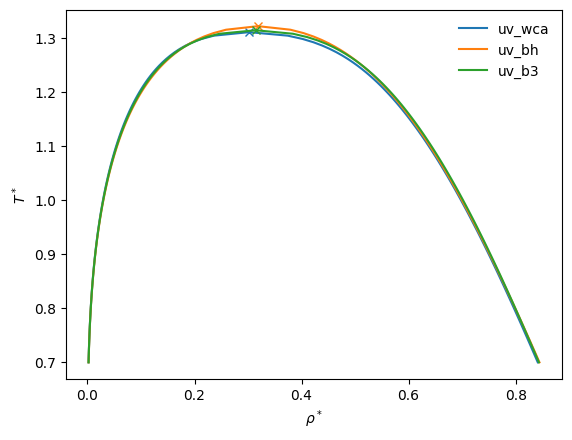

In [225]:
def plot_vle():
    names = ['uv_wca', 'uv_bh', 'uv_b3']
    for name in names:
        axes = plt.gca()
        color = next(axes._get_lines.prop_cycler)['color']
        rep = 12
        att = 6.0
        sigma = 3.7039 # in Angstrom
        eps_k = 150.03 # eps / kB in K
        eos = get_eos(name, rep, sigma, eps_k, att)
        tc = eos.critical_temperature()
        eos_rhol = []
        eos_rhov = []
        temperatures = np.linspace(0.7, 0.99999 *tc, 100)
        for temp in temperatures:
            eos_rhol.append(eos.liquid_density(temp))
            eos_rhov.append(eos.vapor_density(temp))
        plt.plot(eos.critical_density(), eos.critical_temperature(), 'x', color=color)
        plt.plot( eos_rhov, temperatures, color=color)
        plt.plot( eos_rhol, temperatures, color=color,  label='{}'.format(name))
    plt.legend(frameon=False)
    plt.xlabel('$\\rho^*$')
    plt.ylabel('$T^*$')
    return
plot_vle()

In [7]:
uv_b3.res_helmholtz_energy(1,1) - -1.975385053056555

-8.215650382226158e-15

In [8]:
uv_b3.res_helmholtz_energy(1,2) - 0.9239674467936894

-2.9976021664879227e-15

In [9]:
uv_b3.residual_pressure(1,2) - 13.040302811478417

6.572520305780927e-14